In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

# symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "AMZN"]



def get_data(symbol,start_date,end_date):
        # Fetch historical data
    filename = f"{symbol}_{start_date}_to_{end_date}.csv"
    if os.path.exists(filename):
        print("CSV exists, skipping download:", filename)
    else:
        data = yf.download(symbol, start=start_date, end=end_date)
        data.to_csv(filename)
        print("Saved CSV:", filename)
    return pd.read_csv(filename, index_col=0, parse_dates=True)

        
symbol = "AAPL"
start_date = "2015-11-1"  
end_date = "2025-10-31"

# load CSV back into `data`
data = get_data(symbol,start_date,end_date)
print("Loaded CSV rows:", len(data))


# change Price to Date and remove second and third rows
data = data.iloc[2:]
data = data.reset_index().rename(columns={"Price": "Date"})
data.head()


CSV exists, skipping download: AAPL_2015-11-1_to_2025-10-31.csv
Loaded CSV rows: 2516


C:\Users\Lau\AppData\Local\Temp\ipykernel_12128\1656927947.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(filename, index_col=0, parse_dates=True)


,Date,Close,High,Low,Open,Volume
0,2015-11-02,27.20587158203125,27.246283078771686,26.85339419324062,27.12055918351682,128813200
1,2015-11-03,27.5179386138916,27.724485511182642,27.098108142190735,27.11831474782773,182076000
2,2015-11-04,27.38996696472168,27.79857132141872,27.304654569493785,27.64366030440483,179544400
3,2015-11-05,27.26370620727539,27.662787229444895,27.096859658670287,27.473392408705557,158210800
4,2015-11-06,27.29527473449707,27.464376473004577,27.19606955096978,27.30654887180764,132169200


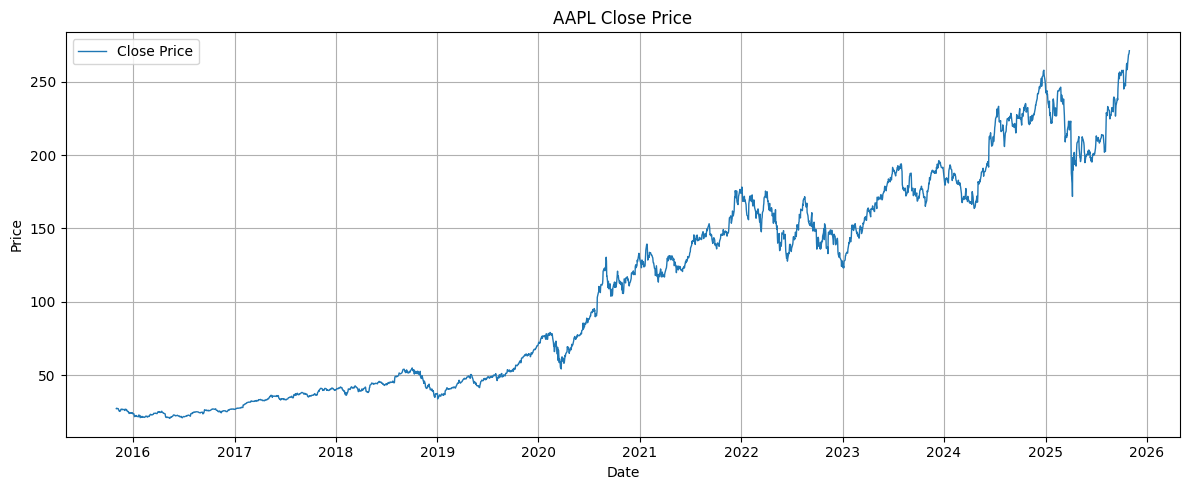

In [8]:
# Ensure Date is datetime and Close is numeric, then plot filtered data
# (plt was already imported in another cell)
if 'Date' in data.columns:
	dates = pd.to_datetime(data['Date'], errors='coerce')
else:
	dates = pd.to_datetime(data.index, errors='coerce')

# convert Close to numeric (coerce bad values to NaN)
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# drop rows with invalid dates or Close values to avoid plotting errors
valid_mask = dates.notna() & data['Close'].notna()
plot_df = data.loc[valid_mask].copy()
plot_dates = pd.to_datetime(plot_df['Date']) if 'Date' in plot_df.columns else pd.to_datetime(plot_df.index)

plt.figure(figsize=(12, 5))
plt.plot(plot_dates, plot_df['Close'].astype(float), label='Close Price', color='tab:blue', linewidth=1)
plt.title(f"{symbol} Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #i_t
        self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        #f_t
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        #c_t
        self.W_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        #o_t
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def forward(self,
                x,
                init_states=None):
        
        """
        assumes x.shape represents (batch_size, sequence_size, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)
            g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        #reshape hidden_seq p/ retornar
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [10]:
# ...existing code...
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Parameters (tune as needed)
SEQ_LEN = 60        # number of past days used to predict
FORCAST = 14        # predict 20 days ahead (target is the value forcast steps after the input window)
BATCH_SIZE = 64
TRAIN_RATIO = 0.8
FEATURES = ["Close", "Volume"]
# 1) prepare series (use Close price)
series = data[FEATURES].dropna().values.astype(np.float32)
n_total = len(series)
if n_total < SEQ_LEN + FORCAST:
    raise ValueError("Not enough data for the chosen SEQ_LEN/forcast")

def get_denom(n_total, series):
    # 2) train / test split indices for scaling (avoid leakage)
    train_end = int(n_total * TRAIN_RATIO)
    train_series = series[:train_end]
    # MinMax scaler using train set
    train_min = train_series.min(axis=0)
    train_max = train_series.max(axis=0)
    scale_denom = (train_max - train_min)
    scale_denom[scale_denom == 0] = 1.0  # avoid div by zero
    
    return train_min, train_max,scale_denom

def scale(x, train_min, scale_denom):
    return (x - train_min) / scale_denom

train_min, train_max, scale_denom = get_denom(n_total, series)
series_scaled = scale(series, train_min, scale_denom)
print("Series scaled shape:", series_scaled.shape)  # (n_total, 1)
# 3) create sequences and targets
def create_sequences(data_arr, seq_len, forcast):
    xs, ys = [], []
    for i in range(0, len(data_arr) - seq_len - (forcast - 1)):
        x = data_arr[i : i + seq_len]
        y = data_arr[i + seq_len + (forcast - 1)]
        xs.append(x)
        ys.append(y)
    return np.stack(xs), np.stack(ys)

X_all, y_all = create_sequences(series_scaled, SEQ_LEN, FORCAST)
y_all = y_all[:, 0:1]
print("X_all shape:", X_all.shape)  # (N, SEQ_LEN, 1)
print("y_all shape:", y_all.shape)  # (N, 1)
# 4) split sequences into train / test by sequence count
n_seq = len(X_all)
train_seq_count = int(n_seq * TRAIN_RATIO)

X_train, y_train = X_all[:train_seq_count], y_all[:train_seq_count]
X_test,  y_test  = X_all[train_seq_count:], y_all[train_seq_count:]

# 5) Dataset wrapper
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()       # shape: (N, seq_len, 1)
        self.y = torch.from_numpy(y).float()       # shape: (N, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SequenceDataset(X_train, y_train)
test_dataset  = SequenceDataset(X_test,  y_test)

# 6) DataLoaders (assign train_loader as requested)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# 7) quick sanity print
print(f"Total series length: {n_total}, sequences: {n_seq}")
print(f"Train sequences: {len(train_dataset)}, Test sequences: {len(test_dataset)}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# ...existing code...


Series scaled shape: (2514, 2)
X_all shape: (2441, 60, 2)
y_all shape: (2441, 1)
Total series length: 2514, sequences: 2441
Train sequences: 1952, Test sequences: 489
X_train shape: (1952, 60, 2), y_train shape: (1952, 1)


In [11]:
import platform


# device selection: prefer CUDA only when running on Windows and CUDA is available
device = torch.device("cuda" if (platform.system() == "Windows" and torch.cuda.is_available()) else "cpu")
print("Platform:", platform.system(), "CUDA available:", torch.cuda.is_available(), "Using device:", device)


Platform: Windows CUDA available: True Using device: cuda


In [12]:
# training hyperparams

# hidden state size used by NaiveCustomLSTM 
ISTRAIN = True
HIDDEN_SIZE = 64  
# LR = 1e-3  
LR = 0.025
EPOCHS = 70
FEATURE_SIZE = len(FEATURES)  # should be 1 for univariate series
# model + simple linear head that maps last hidden state -> scalar prediction
model = NaiveCustomLSTM(input_sz=FEATURE_SIZE, hidden_sz=HIDDEN_SIZE).to(device)
# head = nn.Linear(HIDDEN_SIZE, 1).to(device)
head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(HIDDEN_SIZE, 1)
).to(device)

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=LR)

In [13]:


def start_train():
    for epoch in range(1, EPOCHS + 1):
        model.train()
        head.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)          # shape: (B, seq_len, 1)
            yb = yb.to(device)          # shape: (B, 1)
            optimizer.zero_grad()
            out_seq, _ = model(xb)      # out_seq: (B, seq_len, hidden)
            last_h = out_seq[:, -1, :]  # take last time-step hidden (B, hidden)
            preds = head(last_h)        # (B, 1)
            # compute loss between model predictions and targets (e.g., MSE)
            loss = criterion(preds, yb)
            # backpropagate gradients through model and head parameters
            loss.backward()
            # apply optimizer step to update parameters (Adam)
            optimizer.step() 
            running_loss += loss.item() * xb.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # validation / test eval
        model.eval()
        head.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                out_seq, _ = model(xb)
                preds = head(out_seq[:, -1, :])
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss = val_loss / len(test_loader.dataset) if len(test_loader.dataset) > 0 else float("nan")

        print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.6f}  val_loss: {val_loss:.6f}")
        
        # export model
        torch.save({
            'model_state_dict': model.state_dict(),
            'head_state_dict': head.state_dict(),
        }, 'lstm_price_model_multi.pth')

if ISTRAIN :
    start_train()


Epoch 1/70 — train_loss: 0.139481  val_loss: 0.072662


KeyboardInterrupt: 

In [ ]:
# load checkpoint (use in-memory ckpt if present, otherwise load file)
state =  torch.load('lstm_price_model_multi.pth', map_location=device)
print(state['model_state_dict'].keys())
print(state['head_state_dict'].keys())

odict_keys(['W_i', 'U_i', 'b_i', 'W_f', 'U_f', 'b_f', 'W_c', 'U_c', 'b_c', 'W_o', 'U_o', 'b_o'])
odict_keys(['1.weight', '1.bias'])


In [ ]:


# load weights
model.load_state_dict(state['model_state_dict'])
head.load_state_dict(state['head_state_dict'])

model.eval()
head.eval()

# prepare test data tensor
X_test_tensor = torch.from_numpy(X_test).float().to(device)  # shape: (N, seq_len, 1)

# batch inference
preds_batches = []
with torch.no_grad():
    for i in range(0, X_test_tensor.size(0), BATCH_SIZE):
        xb = X_test_tensor[i : i + BATCH_SIZE]
        out_seq, _ = model(xb)
        preds = head(out_seq[:, -1, :])        # shape (B,1)
        if i == 0:
          print(out_seq.shape, out_seq[:, -1, :].shape)

          print(preds.shape)
          print(preds[:5])
        preds_batches.append(preds.cpu()) # cpu() beause later converting to numpy
# show list length and shapes of elements and total concatenated shape

print("preds_batches shape:",len(preds_batches), len(preds_batches[0]))
print("preds_batches first:",preds_batches[0])







torch.Size([64, 60, 64]) torch.Size([64, 64])
torch.Size([64, 1])
tensor([[0.8527],
        [0.8585],
        [0.8671],
        [0.8756],
        [0.8750]], device='cuda:0')
preds_batches shape: 8 64
preds_batches first: tensor([[0.8527],
        [0.8585],
        [0.8671],
        [0.8756],
        [0.8750],
        [0.8868],
        [0.8947],
        [0.9069],
        [0.9067],
        [0.9164],
        [0.9212],
        [0.9248],
        [0.9297],
        [0.9360],
        [0.9384],
        [0.9456],
        [0.9474],
        [0.9495],
        [0.9510],
        [0.9454],
        [0.9473],
        [0.9431],
        [0.9420],
        [0.9465],
        [0.9426],
        [0.9464],
        [0.9525],
        [0.9571],
        [0.9605],
        [0.9520],
        [0.9575],
        [0.9620],
        [0.9650],
        [0.9447],
        [0.9596],
        [0.9676],
        [0.9587],
        [0.9600],
        [0.9605],
        [0.9611],
        [0.9552],
        [0.9608],
        [0.9557],
     

In [ ]:
preds_scaled = torch.cat(preds_batches, dim=0)
print("before:", preds_scaled.shape)
preds_scaled = preds_scaled.squeeze(-1).numpy()  # shape: (N,)
print("after:", preds_scaled.shape)
print(y_test.shape)


before: torch.Size([489, 1])
after: (489,)
(489, 1)


In [ ]:
# inverse scale to original price units
# NOTE: only the 'Close' feature (first column) should be used to unscale predictions/targets
close_scale = float(scale_denom[0])
close_min = float(train_min[0])

preds_unscaled = preds_scaled.squeeze() * close_scale + close_min
y_test_unscaled = y_test.squeeze(-1) * close_scale + close_min
y_diff_percent = (y_test_unscaled - preds_unscaled) / preds_unscaled * 100.0

print("len of all", len(preds_unscaled), len(y_test_unscaled))

len of all 489 489


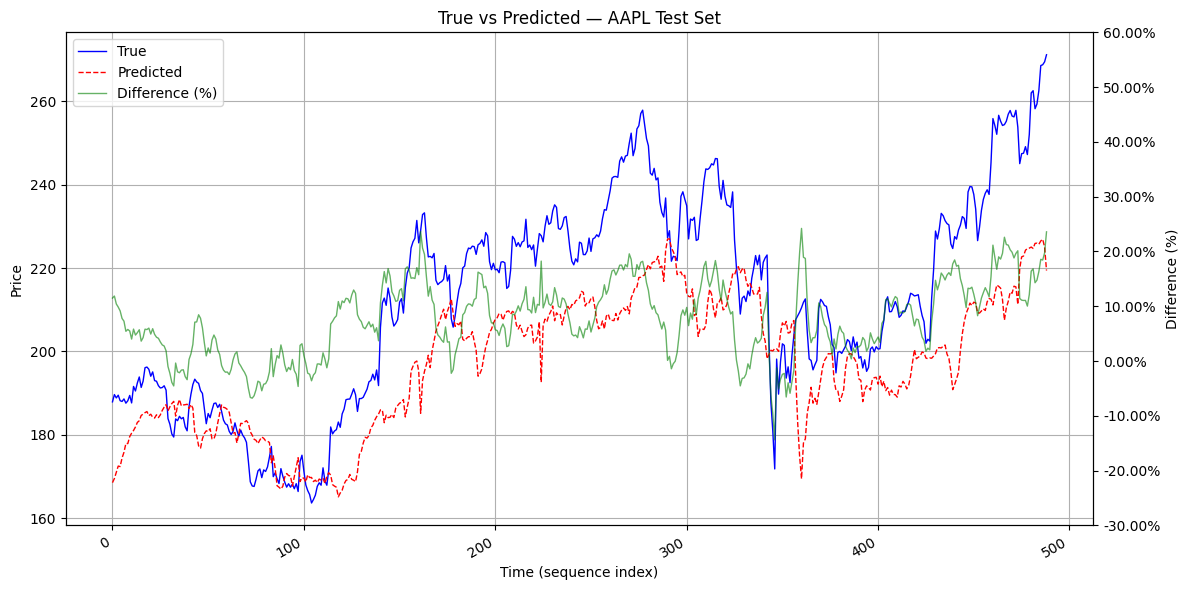

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'True vs Predicted — AAPL Test Set'}, xlabel='Time (sequence index)', ylabel='Price'>,
 <Axes: ylabel='Difference (%)'>)

In [ ]:
# matplotlib inline showing predicted vs true prices (date-aware plotting, percent formatting for diff)
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt



def plot_pred_true(y_true_unscaled,
                   preds_unscaled,
                   dates=None,
                   y_diff_percent=None,
                   clip=CLIP,
                   symbol=None,
                   ylim_diff=(-50, 50),
                   figsize=(12, 6),
                   y_is_percent=False):
    """
    Plot true vs predicted series. If `dates` is provided (array-like, same length as series)
    the x-axis uses actual dates. `y_diff_percent` is plotted on a secondary y-axis and is
    assumed to already be in percent (e.g. -2.5 means -2.5%). If y_is_percent=True the main
    y-axis will be formatted as percent (assumes values are fractions).
    Returns (fig, ax, ax2).
    """
    y_true = np.asarray(y_true_unscaled).squeeze()
    preds = np.asarray(preds_unscaled).squeeze()
    diff = np.asarray(y_diff_percent).squeeze() if y_diff_percent is not None else None

    if y_true.shape[0] != preds.shape[0]:
        raise ValueError("y_true and preds must have the same length")
    if diff is not None and diff.shape[0] != preds.shape[0]:
        raise ValueError("y_diff_percent must have the same length as preds/true")
    if dates is not None:
        dates_arr = pd.to_datetime(np.asarray(dates)).squeeze()
        if dates_arr.shape[0] != preds.shape[0]:
            raise ValueError("dates must have the same length as preds/true")
    else:
        dates_arr = None

    n = len(preds)
    clip_n = min(int(clip), n)
    if clip_n <= 0:
        raise RuntimeError("No data to plot (clip is zero or arrays are empty).")
    start = -clip_n

    fig, ax = plt.subplots(figsize=figsize)
    if dates_arr is not None:
        ax.plot(dates_arr[start:], y_true[start:], label="True", color="blue", linewidth=1)
        ax.plot(dates_arr[start:], preds[start:], label="Predicted", color="red", linestyle="--", linewidth=1)
    else:
        ax.plot(y_true[start:], label="True", color="blue", linewidth=1)
        ax.plot(preds[start:], label="Predicted", color="red", linestyle="--", linewidth=1)

    ax.set_xlabel("Date" if dates_arr is not None else "Time (sequence index)")
    ax.set_ylabel("Price" if not y_is_percent else "Value (%)")
    title_sym = f" — {symbol}" if symbol else ""
    ax.set_title(f"True vs Predicted{title_sym}")
    ax.grid(True)

    # format main y-axis as percent if requested (assumes fractions)
    if y_is_percent:
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, pos: f"{y*100:.2f}%"))

    ax2 = None
    if diff is not None:
        ax2 = ax.twinx()
        ax2.set_ylim(*ylim_diff)
        if dates_arr is not None:
            ax2.plot(dates_arr[start:], diff[start:], label="Difference (%)", color="green", alpha=0.6, linewidth=1)
        else:
            ax2.plot(diff[start:], label="Difference (%)", color="green", alpha=0.6, linewidth=1)
        ax2.set_ylabel("Difference (%)")
        ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, pos: f"{y:.2f}%"))

    # combined legend
    lines, labels = ax.get_legend_handles_labels()
    if ax2 is not None:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc="best")
    else:
        ax.legend(loc="best")

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    return fig, ax, ax2

# Example (uncomment to run):
plot_pred_true(y_test_unscaled, preds_unscaled, dates=None, y_diff_percent=y_diff_percent, ylim_diff=(-30,60), clip=CLIP, symbol=symbol + " Test Set")

In [ ]:
symbol_other = "AAPL"
start_date = "2015-11-1"  
end_date = "2025-10-31"


data = get_data(symbol_other,start_date,end_date)


print("Loaded CSV: rows:", len(data))

# change Price to Date and remove second and third rows
data = data.iloc[2:]
data = data.reset_index().rename(columns={"Price": "Date"})
data[-10:]

CSV exists, skipping download: AAPL_2015-11-1_to_2025-10-31.csv
Loaded CSV: rows: 2516


C:\Users\Lau\AppData\Local\Temp\ipykernel_39336\1656927947.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(filename, index_col=0, parse_dates=True)


,Date,Close,High,Low,Open,Volume
2504,2025-10-17,252.045654296875,253.13461023404025,247.03052706557392,247.77980070207627,49147000
2505,2025-10-20,261.98602294921875,264.1239650925819,255.3824390623343,255.64218177653177,90483000
2506,2025-10-21,262.5155029296875,265.03308188579996,261.5764108568555,261.6263807259345,46695900
2507,2025-10-22,258.19970703125,262.5954395959732,255.18261234613632,262.3956210979312,45015300
2508,2025-10-23,259.3285827636719,260.36758405794774,257.76012648314656,259.68824995662277,32754900
2509,2025-10-24,262.56549072265625,263.87421967110856,258.9290010880386,260.93706434715574,38253700
2510,2025-10-27,268.5496520996094,268.8593494221352,264.3936774471076,264.6234656652487,44888200
2511,2025-10-28,268.7394714355469,269.6286240979669,267.8902885694659,268.7294713644567,41534800
2512,2025-10-29,269.4388122558594,271.1471476128123,266.85129379808274,269.01920560410514,51086700
2513,2025-10-30,271.13714599609375,273.87451306817263,268.2199910571769,271.72657092903916,69886500


In [ ]:
# predict  price using the loaded model + head
# (uses existing variables: model, head, device, SEQ_LEN, FORCAST, scale, train_min, scale_denom)

series_full = data[FEATURES].dropna().values.astype(np.float32)

print(series_full)

n_total = len(series_full)

train_min, train_max, scale_denom = get_denom(n_total, series_full)


series_full_scaled = scale(series_full, train_min, scale_denom)

print("series scaled shape:", series_full_scaled.shape)  # (n_total, 1)
# create sequences for  (reuse create_sequences from notebook)
X_full, y_full = create_sequences(series_full_scaled, SEQ_LEN, FORCAST)
y_full = y_full[:, 0:1]
print("X y shape:", X_full.shape, y_full.shape)  # (N, SEQ_LEN, 1)
if len(X_full) == 0:
    raise RuntimeError("Not enough NVDA data to build a sequence with the configured SEQ_LEN/FORCAST.")







[[2.7205872e+01 1.2881320e+08]
 [2.7517939e+01 1.8207600e+08]
 [2.7389967e+01 1.7954440e+08]
 ...
 [2.6873947e+02 4.1534800e+07]
 [2.6943881e+02 5.1086700e+07]
 [2.7113715e+02 6.9886496e+07]]
series scaled shape: (2514, 2)
X y shape: (2441, 60, 2) (2441, 1)


In [ ]:

# prepare NVDA input tensor and run batch inference
X_full_tensor = torch.from_numpy(X_full).float().to(device)  # (N, seq_len, 1)

def start_infer(tensor, model, head):
  preds_batches = []


  with torch.no_grad():
      for i in range(0, tensor.size(0), BATCH_SIZE):
          xb = tensor[i : i + BATCH_SIZE]
          out_seq, _ = model(xb)
          preds = head(out_seq[:, -1, :])        # shape (B,1)
          if i == 0:
            print(out_seq.shape, out_seq[:, -1, :].shape)

            print(preds.shape)
            print(preds[:5])
          preds_batches.append(preds.cpu()) # cpu() beause later converting to numpy
  return preds_batches
preds_batches = start_infer(X_full_tensor, model, head)



# ensure preds is a numpy array so subsequent ops are numpy-based (y_nvda is numpy)
preds_full_scaled = torch.cat(preds_batches, dim=0).squeeze().cpu().numpy()   # shape matches preds_nvda_unscaled
# inverse scale to original price units (use first feature scale)
preds_full_unscaled = preds_full_scaled * float(scale_denom[0]) + float(train_min[0])
y_full_unscaled = (y_full * float(scale_denom[0]) + float(train_min[0])).squeeze()
y_full_diff_percent = (y_full_unscaled - preds_full_unscaled) / preds_full_unscaled * 100.0

y_full_diff_percent.shape


torch.Size([64, 60, 64]) torch.Size([64, 64])
torch.Size([64, 1])
tensor([[0.0140],
        [0.0079],
        [0.0045],
        [0.0044],
        [0.0063]], device='cuda:0')


(2441,)

In [ ]:
# export for final formula
export_y = y_full_diff_percent.copy()
export_date = data['Date'].copy()
export = pd.DataFrame({
    'Date': export_date.iloc[SEQ_LEN + FORCAST -1 :],
    'LSTMDIFF': export_y
})
export.to_csv('lstm_price_diff_export.csv', index=False)
print("Exported CSV rows:", len(export))
export[-10:]

Exported CSV rows: 2441


,Date,LSTMDIFF
2504,2025-10-17,12.132821
2505,2025-10-20,16.422781
2506,2025-10-21,16.833424
2507,2025-10-22,14.292730
2508,2025-10-23,14.768113
2509,2025-10-24,16.338686
2510,2025-10-27,18.567429
2511,2025-10-28,18.436165
2512,2025-10-29,19.743973
2513,2025-10-30,23.582354


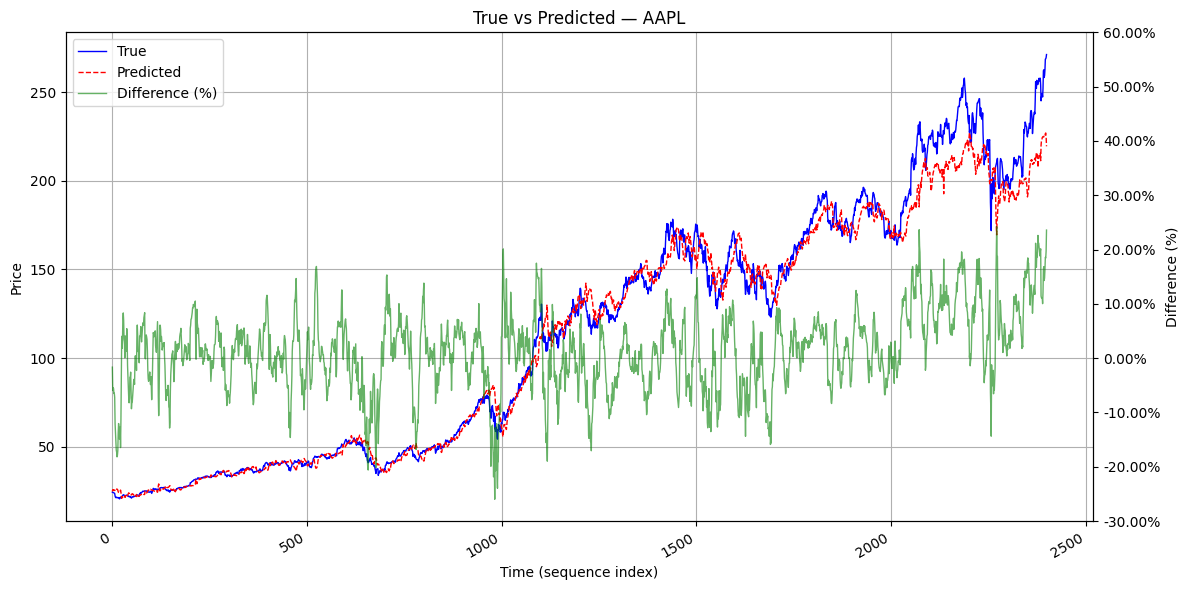

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'True vs Predicted — AAPL'}, xlabel='Time (sequence index)', ylabel='Price'>,
 <Axes: ylabel='Difference (%)'>)

In [ ]:

plot_pred_true(y_full_unscaled,
               preds_full_unscaled,
               y_diff_percent=y_full_diff_percent,
               clip=CLIP,
               symbol=symbol_other,
               ylim_diff=(-30, 60)
                )